#### This code generates large dataframe containing multiple timeseries

In [1]:
%matplotlib inline
from time import time
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

#from sklearn.model_selection import cross_val_score
#from sklearn.metrics import roc_curve, auc

from pandas.tseries.offsets import *

Using TensorFlow backend.


#### parameters to set

In [2]:
# fix random seed for reproducibility
np.random.seed(45)

n_series = 4
start_date = '2017-08-01 00:00:00'
end_date = '2017-08-01 13:59:59'

# regular behaviour
max_noise_amplitude = 0.1 # all the timeseries will have values between 0 and 1


# tuning parameters
refh = 12
subh = 1
chance = refh/(subh+refh)
cut = chance + (1-chance) * 0.05
print('chance:',chance, '\tcut:', cut)
ref = refh * Hour()
sub = subh * Hour()

chance: 0.9230769230769231 	cut: 0.926923076923077


#### generate normal data

In [3]:
dti=pd.DatetimeIndex(start=start_date,end=end_date, freq='s')
n_timesteps = len(dti)
df = pd.DataFrame()
for s in range(n_series):
    v = np.random.normal(random.random()/2, max_noise_amplitude/random.randint(1, 5), n_timesteps) 
    df['link '+str(s)] = pd.Series(v)
df['Flag']=0
df.index = dti

#### generate anomalies

In [4]:
def fixed_anomaly():
    duration = 3600
    start = refh * 3600
    end = min(start+duration, n_timesteps)
    print('affected:', df.iloc[start].name, df.iloc[end].name)
    df.iloc[start:end,s] = df.iloc[start:end,s] + 0.1
    df.iloc[start:end,n_series]=1
        
fixed_anomaly()

df.head()

affected: 2017-08-01 12:00:00 2017-08-01 13:00:00


,link 0,link 1,link 2,link 3,Flag
2017-08-01 00:00:00,0.102521,0.319411,0.012703,0.464582,0
2017-08-01 00:00:01,0.108370,0.291025,-0.028060,0.377599,0
2017-08-01 00:00:02,0.091983,0.314733,-0.044223,0.459423,0
2017-08-01 00:00:03,0.096754,0.333237,0.049796,0.413948,0
2017-08-01 00:00:04,0.070071,0.306117,-0.116572,0.480024,0


#### enforce range

In [5]:
df[df<0] = 0
df[df>1] = 1

#### plot timeseries

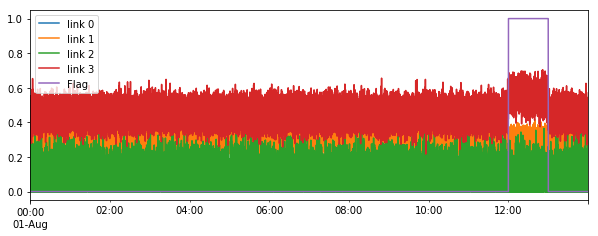

In [6]:
df.plot(figsize=(10,3.5))

#### create NN

In [7]:
def getModel():
    with tf.device('/gpu:1'):
        model = Sequential()
        model.add(Dense(units=n_series, input_shape=(n_series,), activation='relu' ))
        #model.add(Dropout(0.5))
        model.add(Dense(units=n_series, activation='relu'))    
        #model.add(Dropout(0.5))
        model.add(Dense(units=1, activation='sigmoid') )# 
        
#         model.compile(loss='hinge', optimizer='sgd', metrics=['binary_accuracy'])
#         model.compile(loss='mse',optimizer='rmsprop', metrics=['accuracy'])
        model.compile(loss='binary_crossentropy',optimizer='rmsprop', metrics=['accuracy','binary_accuracy'])
#         model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['binary_accuracy'])
#         layer.get_weights()
    return model

def plotHist(hist):
    es=len(hist.history['loss'])
    x = np.linspace(0,es-1,es)
    plt.plot(x, hist.history['loss'], '--', linewidth=2, label='loss')
    plt.plot(x, hist.history['acc'], '-', linewidth=2, label='acc')
    plt.legend()
    plt.show()

#### functions

In [8]:
def scaled_accuracy(accuracy, ref_samples, sub_samples):
    chance = float(ref_samples)/(ref_samples+sub_samples)
    rescale = 1/(1 - chance)
    return (accuracy-chance)*rescale

def check_for_anomaly(ref, sub):
    
    y_ref = pd.DataFrame([0] * ref.shape[0])
    y_ref.index=ref.index
    X_ref=ref
    del X_ref['Flag']
    
#     print(X_ref.shape)
#     print(X_ref.head())
#     print(y_ref.shape)
#     print(y_ref.head())
    
    y_sub = pd.DataFrame([1] * sub.shape[0])
    y_sub.index=sub.index
    X_sub=sub
    del X_sub['Flag']
    
    
#     print(X_sub.shape)
#     print(X_sub.head())
#     print(y_sub.shape)
#     print(y_sub.head())
    
    # separate Reference and Subject into Train and Test
    X_ref_train, X_ref_test, y_ref_train, y_ref_test = train_test_split(X_ref, y_ref, test_size=0.3, random_state=42)
    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)
    
    # combine training ref and sub samples
    X_train = pd.concat([X_ref_train, X_sub_train])
    y_train = pd.concat([y_ref_train, y_sub_train])

    # combine testing ref and sub samples  
    X_test = pd.concat([X_ref_test, X_sub_test])
    y_test = pd.concat([y_ref_test, y_sub_test])
    
    #suffle the data
    
    X_train_s, y_train_s = shuffle(X_train, y_train)
   # X_test_s, y_test_s = shuffle(X_test, y_test) # probably not needed
    
    X_train_s = X_train_s.reset_index(drop=True)
    y_train_s = y_train_s.reset_index(drop=True)
    
    
#     print(X_train_s.shape)
#     print(X_train_s.head(20))
#     print(y_train_s.shape)
#     print(y_train_s.head(20))
    
    m=getModel()
    hist = m.fit(X_train_s.values, y_train_s.values, epochs=10, verbose=1, shuffle=True, batch_size=128)
    plotHist(hist)
    
    loss_and_metrics = m.evaluate(X_test.values, y_test.values)#, batch_size=256)
    print(loss_and_metrics)
    print(scaled_accuracy(loss_and_metrics[1], ref.shape[0], sub.shape[0]))
#   plot_roc(fpr, tpr, auc_score)
    
    #print(m.summary())
    #print('x'*20)
    #print(m.get_config())
    #print('x'*20)
    #print(m.get_weights())
    #print('x'*20)
    
    l1=m.get_layer('dense_1')
    #print(l1)
    print(l1.get_weights())
    return 

#### Run it

In [9]:
start = df.index.min()
start.seconds=0
start.minutes=0
rf=start+ref
ref_df = df[(df.index < rf)]
sub_df = df[(df.index >= rf) & (df.index < rf+sub)]
print("\trefes:" , ref_df.shape[0], "\tsubjects:", sub_df.shape[0])
check_for_anomaly(ref_df, sub_df)

	refes: 43200 	subjects: 3600
Epoch 1/10
32760/32760 [==============================] - 244s - loss: 0.6807 - acc: 0.9231 - binary_accuracy: 0.9231   
Epoch 2/10
 3712/32760 [==>...........................] - ETA: 211s - loss: 0.6807 - acc: 0.9232 - binary_accuracy: 0.9232

KeyboardInterrupt: 

##### 